<h1 align="center">SpaceX  Falcon 9 first stage /br 
Landing Prediction - Machine Learning Prediction</h1>

<div style="text-align:center">
    <img src='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif'>
</div>

Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch. In this notebook, we will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


## Import Libraries and Define Auxiliary Functions

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,   accuracy_score
import joblib
import os
import warnings

This function is to plot the confusion matrix:

In [33]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

Mute the warnings in the output:

In [34]:
warnings.filterwarnings("ignore")

## Load the dataframe


In [35]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
data.sample(3)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
35,36,2017-08-14,Falcon 9,2910.0,ISS,KSC LC 39A,True RTLS,1,True,False,True,5e9e3032383ecb267a34e7c7,4.0,1,B1039,-80.603956,28.608058,1
38,39,2017-10-09,Falcon 9,9600.0,PO,VAFB SLC 4E,True ASDS,1,True,False,True,5e9e3033383ecbb9e534e7cc,4.0,1,B1041,-120.610829,34.632093,1
53,54,2018-07-25,Falcon 9,9600.0,PO,VAFB SLC 4E,True ASDS,1,True,False,True,5e9e3033383ecbb9e534e7cc,5.0,4,B1048,-120.610829,34.632093,1


In [42]:
X_data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X_data.head(3)

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create a Variable Y:


In [43]:
Y=data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

Standardize the data in **X**, then reassign it to the variable **X**:

In [44]:
# students get this 
X= preprocessing.StandardScaler().fit_transform(X_data)
X

array([[-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
         5.38516481, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534,  9.43398113]])

We split the data into training and testing data using the  function  **train_test_split**.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function **GridSearchCV**.


## Split the data into training and testing

In [45]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y,test_size=0.2,random_state=42)

We can see we only have 18 test samples:


In [46]:
Y_test.shape

(18,)

## Logistic regression object and GridSearchCV object

In [47]:
lr=LogisticRegression()

parameters ={"C":[0.001,0.01, 0.1, 1],'penalty':['l1','l2'], 'solver':['lbfgs', 'liblinear','saga','newton-cg']}# l1 lasso l2 ridge
logreg_cv= GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)
best_parameters = logreg_cv.best_params_
best_score= logreg_cv.best_score_

We output the **GridSearchCV**> object for logistic regression. We display the best parameters using the data attribute **best_params\_** and the accuracy on the validation data using the data attribute **best_score\_**:


In [48]:
print("tuned hpyerparameters :(best parameters) ",best_parameters)
print("accuracy :",best_score)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285715


Accuracy on the test data using the method **score**:


In [49]:
best_model=logreg_cv.best_estimator_
best_model

LogisticRegression(C=0.01)

In [50]:
accuracy_lr= best_model.score(X_test, Y_test)
accuracy_lr

0.9444444444444444

In [51]:
final_lr=LogisticRegression(C=0.01, penalty='l1', solver='saga')
final_lr.fit(X_train, Y_train)
Y_pred=final_lr.predict(X_test)
accuracy_score(Y_test, Y_pred)


0.7777777777777778

Lets look at the confusion matrix:


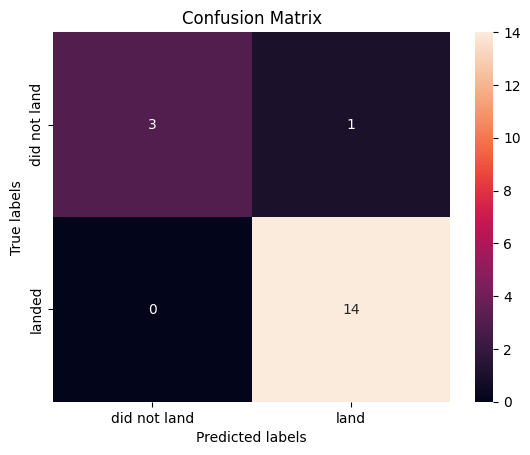

In [52]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## Support Vector Machine object and GridSearchCV object:

In [53]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv= GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [54]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8464285714285713


Accuracy on the test data using the method **score**:

In [55]:
best_svc=svm_cv.best_estimator_
accuracy_svc= best_svc.score(X_test, Y_test)
accuracy_svc

0.8888888888888888

We can plot the confusion matrix:

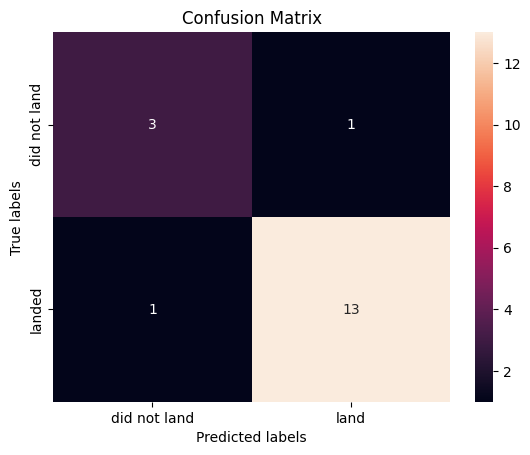

In [56]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Decision tree classifier object and GridSearchCV object


In [57]:
parameters = {'criterion': ['gini', 'entropy','log_loss'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv= GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [58]:
print("tuned hpyerparameters: (best)",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters: (best) {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8607142857142858


Accuracy of tree_cv on the test data using the method **score**:

In [59]:
best_tree=tree_cv.best_estimator_
accuracy_tree= best_tree.score(X_test, Y_test)
accuracy_tree

0.8888888888888888

We can plot the confusion matrix


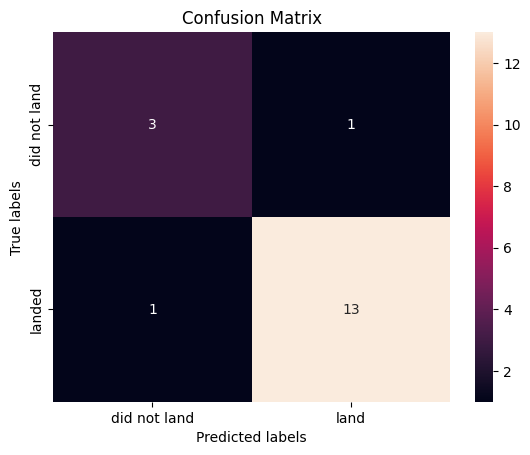

In [60]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## K nearest neighbors object and GridSearchCV object

In [61]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv= GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [62]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8464285714285715


We can plot the confusion matrix

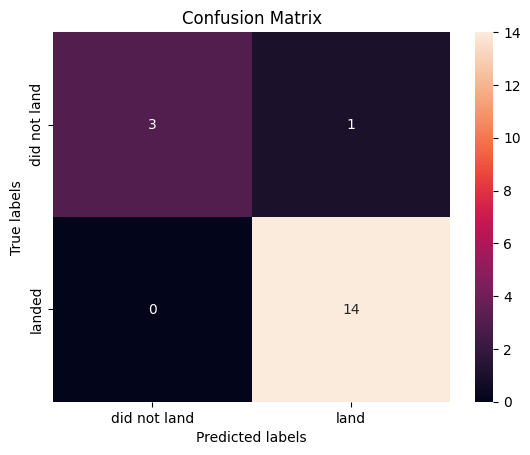

In [63]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Accuracy of tree_cv on the test data using the method **score**:

In [64]:
best_knn=knn_cv.best_estimator_
accuracy_knn= best_knn.score(X_test, Y_test)
accuracy_knn

0.9444444444444444

## Evaluating the accuracy of the models

Let's see the model's accuracy in a bar chart:

In [65]:
scores_dict = {'LogisticRegression':accuracy_lr, 'SupportVectorMachine': accuracy_svc, 'DecisionTree':accuracy_tree, 'KNeighbors':accuracy_knn}

In [66]:
df_scores = pd.DataFrame.from_dict(scores_dict, orient='index', columns=['Accuracy'])
df_scores

,Accuracy
LogisticRegression,0.944444
SupportVectorMachine,0.888889
DecisionTree,0.888889
KNeighbors,0.944444


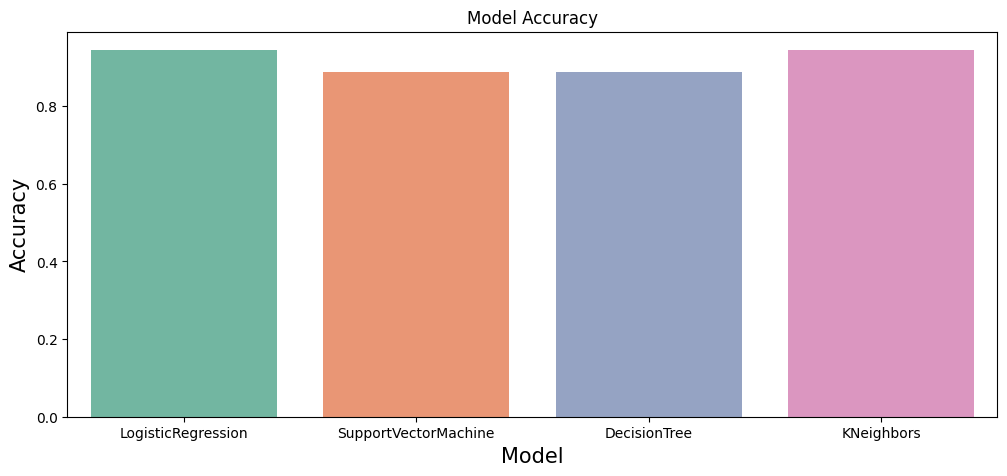

In [72]:
plt.figure(figsize=(12, 5))
sns.barplot(x=df_scores.index, y="Accuracy", data=df_scores, palette='Set2')
plt.title("Model Accuracy")
plt.xlabel("Model",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)

plt.show()

Now,we can determine the best model:

In [68]:
                                    
bestalgorithm = max(scores_dict, key=scores_dict.get)

print('The best model is', bestalgorithm,', with a score of', scores_dict[bestalgorithm])

The best model is LogisticRegression , with a score of 0.9444444444444444


Let's save the best model:

In [69]:
best_model

LogisticRegression(C=0.01)

In [70]:
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(project_dir, "models")
os.makedirs(data_dir, exist_ok=True)

In [71]:
model_path = os.path.join(data_dir, "spacex_classifier.pkl")
result=joblib.dump(best_model, model_path)